<a href="https://colab.research.google.com/github/stanlee321/2019-DL-Beginners-NVIDIA-GPU-accelerated-Platform-in-an-instant/blob/master/Demo_semantic_search_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install tensorflow_text

In [57]:
!nvidia-smi

Tue Jun 16 00:15:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |   2331MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [0]:
import tensorflow_text
import tensorflow_hub as hub

# from rake_nltk import Rake
import tensorflow.compat.v2 as tf

In [60]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# The 16-language multilingual module is the default but feel free
# to pick others from the list and compare the results.
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #@param ['https://tfhub.dev/google/universal-sentence-encoder-multilingual/3', 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3']



In [0]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.load(module_url)


In [0]:
def embed_text(input_text):
    #with tf.device('/gpu:0'):
    return embed(input_text)

In [0]:
def prepare_similarity(vectors):
    similarity=cosine_similarity(vectors)
    return similarity

def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [(i,sentence_list[i]) for i in indices]

In [0]:
# Some texts of different lengths.
english_sentences = ["dog", "Puppies are nice.", "I enjoy taking long walks along the beach with my dog."]
italian_sentences = ["cane", "I cuccioli sono carini.", "Mi piace fare lunghe passeggiate lungo la spiaggia con il mio cane."]
spanish_sentences = ["El perro", "buen perro", "amo mucho salir a pasear con mi perro"]
japanese_sentences = ["犬", "子犬はいいです", "私は犬と一緒にビーチを散歩するのが好きです"]


# Compute embeddings.
en_result = embed_text(english_sentences)
it_result = embed_text(italian_sentences)
sp_result = embed_text(spanish_sentences)
ja_result = embed_text(japanese_sentences)

# Compute similarity matrix. Higher score indicates greater similarity.
similarity_matrix_en = np.inner(en_result, sp_result)
similarity_matrix_it = np.inner(en_result, it_result)
similarity_matrix_ja = np.inner(en_result, ja_result)

In [67]:
similarity_matrix_en

array([[0.85105795, 0.6538782 , 0.43803352],
       [0.42044345, 0.5356836 , 0.3181645 ],
       [0.21767904, 0.25152522, 0.63525796]], dtype=float32)

Text(0.5, 1.0, 'Semantic Textual Similarity')

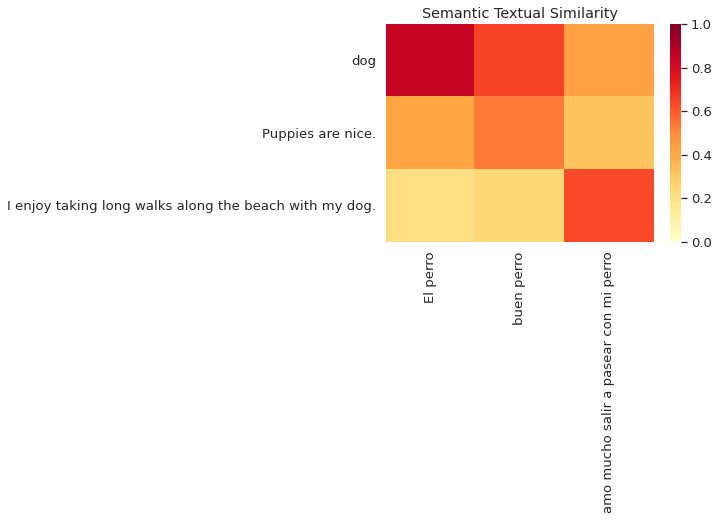

In [66]:
sns.set(font_scale=1.2)
g = sns.heatmap(
    similarity_matrix_en,
    xticklabels=spanish_sentences,
    yticklabels=english_sentences,
    vmin=0,
    vmax=1,
    cmap="YlOrRd")

g.set_xticklabels(spanish_sentences, rotation=90)
g.set_title("Semantic Textual Similarity")

## Practical example

In [0]:
input_file_path = "https://raw.githubusercontent.com/stanlee321/NLP-and-industry/master/data/reports/all_reports.csv"

df = pd.read_csv(input_file_path)
print(df.shape)
df.head()



(21463, 1)


,reports
0,"Falla en la body III, error 19 en varias oport..."
1,Falla en light tester expulsion de latas deja...
2,Falla en printer mensaje constantede area de ...
3,Falla en body III stop relay safety se reinic...
4,Verificacion de motor DC del desnatador que sa...


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21463 entries, 0 to 21462
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reports  21463 non-null  object
dtypes: object(1)
memory usage: 167.8+ KB


In [0]:
sentence_list =  list(df["reports"].values)

print(len(sentence_list))
print(sentence_list[:10])


21463
['Falla en la body III, error 19 en varias oportunidades, se restablecio ', ' Falla en light tester expulsion de latas deja pasar 4 latas con defecto, se coloco en modo learner y se subio la sencibilidad, pruebas Ok ', ' Falla en printer mensaje constantede area de seguridad, se restablecio ', ' Falla en body III stop relay safety se reinicio nuevamente se restauro falla ', 'Verificacion de motor DC del desnatador que salio del tanque superiror,  encontrandose este con corto circuito en un grupo de bobinas del inducido, por reembobinar ', ' Se realizo mtto de motor DC desnatador tanque subterraneo se encontro con colector contaminado con desgaste de carbon y coolant, portaq escobolillas recalentados y deformados,  se coloco tapa y portaescobillas del otro dañado, falta cambiar los carbones y pruebas ', '  Instalacion de cable  y corraza para motor del filtro prensa, inst. de selenoides, por culminar conecciones ', 'Se concluyo con las conecciones en la filtro prensa, revision del

In [0]:
batch_size = 2048


list_df = [df[i:i+batch_size][["reports"]].values for i in range(0,df.shape[0], batch_size)]

In [0]:
language_embeddings = []
print('\nComputing  embeddings')

for batch in list_df:
    language_embeddings.extend(embed_text(batch))
    print(len(batch))


Computing  embeddings
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
983


In [0]:
print(len(language_embeddings))

21463


In [0]:
%%capture

!pip install simpleneighbors[annoy]


In [0]:
from simpleneighbors import SimpleNeighbors

In [0]:
from tqdm import trange

In [0]:
embedding_dimensions = len(list(language_embeddings)[0])
embedding_dimensions

512

In [0]:
num_index_trees = 40
print('\nAdding embeddings to index')

index = SimpleNeighbors(embedding_dimensions, metric='dot')



Adding embeddings to index


In [0]:
for i in trange(len(sentence_list)):
    index.add_one(sentence_list[i], language_embeddings[i])

100%|██████████| 21463/21463 [51:06<00:00,  7.00it/s]


In [0]:
index.build(n=num_index_trees)

In [0]:
sample_query = 'Falla en sensor'  #@param ["Global warming", "Researchers made a surprising new discovery last week.", "The stock market fell four points.", "Lawmakers will vote on the proposal tomorrow."] {allow-input: true}
num_results = 50  #@param {type:"slider", min:0, max:100, step:10}

query_embedding = embed_text(sample_query)[0]
search_results = index.nearest(query_embedding, n=num_results)

print(' sentences similar to: "{}"\n'.format(sample_query))
search_results

 sentences similar to: "Falla en sensor"



['Falla en sensores del desembobinador desalineados ',
 ' Alineado de sensores en desenbobinador ',
 ' Falla en sensores del desembobinador, se restablecio ',
 ' Falla en sensores del desembobinador, se restablecio ',
 ' Desconexion de sensores de trokel de cupper',
 'Falla desembobinador por sensores ,',
 ' limpiado del sensor de flama',
 ' limpiado del sensor de flama',
 'Falla desembobinador por sensores se alineo,',
 ' Falla desembobinador por sensores desalineados se repuso,',
 'Falla sensor de lengüeta de paletizadora conector de sensor suelto se ajusto,',
 ' Mantenimiento de sensores en inside spray  ',
 ' Falla en el sensor del volante de la Body I.',
 'uvicacion de sensores,',
 'uvicacion de sensores,',
 'Falla sensor de stop aire en entrada de nekers se laino,',
 ' Falla en desembinador sensor desalineado, se alineo.',
 ' Calibracion de sensor sencon,',
 ' Falla en sensor PRX25 de transporte, sensor  no se encontraba en su posición ',
 'Falla en sensor de salida light tester,

In [0]:
def generate_matches(df, search_results):

    dfs_list = []

    for comment in search_results:
        dfs_list.append(df[df.loc(axis=1)["reports"] == comment])
        
    return pd.concat(dfs_list, axis=0)

## Save model

In [0]:
index.save("mante_comments_emb")

In [0]:
index_2 = SimpleNeighbors(embedding_dimensions, metric='dot')

## Load Model

In [0]:
index_load = index_2.load("mante_comments_emb")

In [52]:
sample_query = 'Mantenimiento anual motor'  #@param ["Global warming", "Researchers made a surprising new discovery last week.", "The stock market fell four points.", "Lawmakers will vote on the proposal tomorrow."] {allow-input: true}
num_results = 50  #@param {type:"slider", min:0, max:200, step:5}

query_embedding = embed_text(sample_query)[0]
search_results = index_load.nearest(query_embedding, n=num_results)

print(' sentences similar to: "{}"\n'.format(sample_query))


df_query = generate_matches(df, search_results)

search_results


 sentences similar to: "Mantenimiento anual motor"



['Mantenimiento anual',
 'Mantenimiento anual',
 'Mantenimiento anual',
 'mantenimiento anual',
 'mantenimiento anual',
 'mantenimiento anual',
 'Mantenimiento mensual',
 'Mantenimiento mensual',
 'Mantenimiento mensual ',
 'Mantenimiento mensual',
 'llenado de cartillas de motores',
 'Habilitacion motores tablero carpinteria ',
 ' Mantenimiento de motor M45 de transporte ',
 ' Mantenimiento de motor M45 de transporte ',
 ' Apoyo en suspension de motor de ciclon ',
 ' Barnizado de motor de coolant ',
 'Mantenimiento electrico ',
 'Mantenimiento electrico  ',
 'Fiesta de fin de año',
 'Fiesta de fin de año ',
 'Fiesta de fin de Año',
 'motor final body y nave produccion ',
 'Medicion de distancias motores nuevo transporte.',
 'Mantenimiento Anual ',
 'Mantenimiento Anual ',
 'Mantenimiento Anual ',
 'Mantenimiento Anual ',
 'Mantenimiento Anual',
 'Mantenimiento Anual',
 'Mantenimiento Anual',
 'Mantenimiento Anual ',
 'Mantenimiento Anual ',
 'Mantenimiento Anual ',
 'Mantenimiento Anu

In [53]:
df_query.head()

,reports
1741,Mantenimiento anual
1742,Mantenimiento anual
1743,Mantenimiento anual
1741,Mantenimiento anual
1742,Mantenimiento anual


In [56]:
df_query["reports"] = df_query["reports"].str.lstrip()
df_query["reports"] = df_query["reports"].str.rstrip()
df_query.drop_duplicates(subset='reports', keep="first")

,reports
1741,Mantenimiento anual
11833,mantenimiento anual
1380,Mantenimiento mensual
4385,llenado de cartillas de motores
11546,Habilitacion motores tablero carpinteria
209,Mantenimiento de motor M45 de transporte
14844,Apoyo en suspension de motor de ciclon
15655,Barnizado de motor de coolant
2529,Mantenimiento electrico
13054,Fiesta de fin de año


In [0]:
df_query.reset_index(inplace=True, drop=True)

In [0]:
df_query.to_excel("BUSQUEDAS_mante.xlsx")